# Resonador de 6 GHz y 30K


Autor: Kelvin Ramos

Descripción: Diseño y simulación de un resonador de cuarto de onda acoplado a una linea de transmisión coplanar. La frecuencia estimada es de 4GHz y el factor de calidad de 30K.

Procedimiento:
1. Función para estimar la longitud del resonador
2. Librerias necesarias para el diseño del resonador
4. Diseño del resonador
5. Librerias necesarias para la simulacion
6. Ejecutar la simulacion

In [5]:
# from PIL import Image
# im=Image.open('image/resonator.png')
# im.show()

## 1. Función para estimar la longitud del resonador

In [6]:
import numpy as np
from scipy.constants import c

Un resonador $\lambda/4$ tiene su frecuencia de resonancia fundamental

$$f_0=\frac{c}{4L\sqrt{\epsilon_{eff}}}$$

donde $\epsilon_{eff}$ es la constante efectiva del medio por donde se propaga el campo electromagético, $L$ es la longitud del resonador y $c$ la velocidad de la luz.

In [7]:
## estimación de la longitud del resonador para una freq = 4GHz
eff=(11.9+1)/2 ## Si y aire
f=6e9 #frecuencia del resonador
def longitud(x):
    l=c/(4*np.sqrt(eff)*x)*1e3 # longitud en mm
    return print(r'longitud l = {:.4f} mm para f0 = {} GHz'.format(l,x*1e-9))

In [8]:
longitud(f)

longitud l = 4.9185 mm para f0 = 6.0 GHz


## 2. Librerias para el diseño de un resonador

### 2.1 Paquete qiskit-metal

Para el diseño del resonador usaremos qiskit-metal https://qiskit.org/ecosystem/metal/

In [9]:
import qiskit_metal as metal #importamos la librería qiskit metal

In [10]:
#metal.open_docs() ## para más informacion

### 2.2 Modulos de qiskit-metal

In [11]:
## importo los modulos
from qiskit_metal import designs, draw ## para crear y dibujar diseños de circuitos
from qiskit_metal import MetalGUI, Dict, open_docs ## interfaz grafica, Diccionario, online doc 

In [12]:
#open_docs
#Dict(a=1,b=2)
#MetalGUI(design)

In [13]:
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent


### 2.3 Paquetes con los componentes del resonador

In [14]:
## Linea y Meandro: basado en lineas de transmisión complanar
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander ## meandro cpw
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder ## linea cpw

In [15]:
## Terminales y acoplamientos: basado en lineas de transmisión complanar
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven #bonding
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround #open-end
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround #short-end
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee #capacitor

## 3. Diseño del resonador

### 3.1 Configurando el chip

In [16]:
# Definimos la forma del del chip en donde estará el resonador
design = designs.DesignPlanar()
# información del objeto  
design.chips 
####DesignPlanar: objeto, chips: atributo
design.overwrite_enabled = True

In [17]:
design._chips['main']['size']['size_x'] = '4mm'
design._chips['main']['size']['size_y'] = '3mm'
design._chips['main']['size']['size_z'] = '-200um'
design._chips.main.size['center_x'] = '2.0mm'
design._chips.main.size['center_y'] = '1.5mm'
design._chips

{'main': {'material': 'silicon',
  'layer_start': '0',
  'layer_end': '2048',
  'size': {'center_x': '2.0mm',
   'center_y': '1.5mm',
   'center_z': '0.0mm',
   'size_x': '4mm',
   'size_y': '3mm',
   'size_z': '-200um',
   'sample_holder_top': '890um',
   'sample_holder_bottom': '1650um'}}}

In [18]:
gui = MetalGUI(design)

In [19]:
design.variables['cpw_width'] = '20um' #S from reference 2
design.variables['cpw_gap'] = '11um' #W from reference 2

### 3.2 Diseño el Capacitor

In [20]:
## configuro la ubicacion del capacitor y sus parametros
ubi_1= Dict(pos_x='2.0mm', pos_y='1.5mm', prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='160um', down_length='100um', fillet='90um', hfss_wire_bonds=True)

### agrego al diseño
Capacitor = CoupledLineTee(design, 'Capacitor', options=ubi_1)

gui.rebuild()
gui.autoscale()

In [21]:
#MetalGUI(design).autoscale()

### 3.3 Diseño del las terminales de la linea 

In [22]:
# Driven Lauchpad 1

x1 = '1.0mm'
y1 = '1.5mm'
ops_1 = Dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', lead_length='10um', 
             pad_width='120um', pad_gap='61um', trace_width='20um', trace_gap='11um')
LP1 = LaunchpadWirebondDriven(design, 'LP1', options = ops_1)

# Driven Launchpad 2

x2 = '3.0mm'
y2 = '1.5mm'
ops_2 = Dict(chip='main', pos_x=x2, pos_y=y2, orientation='180', lead_length='10um',
             pad_width='120um', pad_gap='61um', trace_width='20um', trace_gap='11um')
LP2 = LaunchpadWirebondDriven(design, 'LP2', options = ops_2)


# Rebuild the GUI
gui.rebuild()
gui.autoscale()

In [23]:
#MetalGUI(design).autoscale()

### 3.4 Linea de Transmision

In [24]:
## Conecto LP1 con el extremo izquierdo del capacitor
opt_line = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='10um', hfss_wire_bonds = True, lead=Dict(end_straight='0.0mm'),
        pin_inputs=Dict(start_pin=Dict(component='LP1', pin='tie'),
                        end_pin=Dict(component='Capacitor', pin='prime_start')
                        )
               )

linea_1 = RoutePathfinder(design, 'linea_1', options = opt_line )

# Rebuild the GUI
gui.rebuild()
gui.autoscale() 


In [25]:
## uno el extremo derecho del capacitor con LP2
opt_line2 = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='10um', hfss_wire_bonds = True,
        lead=Dict(end_straight='0.0mm'),
                 pin_inputs=Dict(start_pin=Dict(component='Capacitor',pin='prime_end'),
                                 end_pin=Dict(component='LP2', pin='tie')
                                )
                )

linea_2 = RoutePathfinder(design, 'linea_4', options = opt_line2)
#### LP2 capacitorb


# Rebuild the GUI
gui.rebuild()
gui.autoscale() 

In [26]:
#MetalGUI(design).autoscale()

### 3.4 Diseño del Meandro

In [27]:
## defino el extremo cortocircuitado del resonador

otg1 = ShortToGround(design, 'otg1', options=Dict(chip='main', pos_x='2.5mm',  pos_y='0.6mm',
                                                  orientation='0'))

## uno el extremo cortocircuitado con el extremo inferior del capacitor

meandro_1 = RouteMeander(design, 'meandro_1',  options=Dict(chip='main',
        trace_width ='20um',
        trace_gap ='11um', 
        total_length='4.9185mm',  
        hfss_wire_bonds = True,
        fillet='90um',
        lead = Dict(start_straight='300um', end_straight='10um'),
        meander=Dict(spacing='200um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor', pin='second_end'),
            end_pin=Dict(component='otg1', pin='short')), ))

# rebuild the GUI
gui.rebuild()
gui.autoscale()

In [28]:
#MetalGUI(design).autoscale()

In [29]:
meandro_1.options

{'chip': 'main',
 'layer': '1',
 'pin_inputs': {'start_pin': {'component': 'Capacitor', 'pin': 'second_end'},
  'end_pin': {'component': 'otg1', 'pin': 'short'}},
 'fillet': '90um',
 'lead': {'start_straight': '300um',
  'end_straight': '10um',
  'start_jogged_extension': '',
  'end_jogged_extension': ''},
 'total_length': '4.9185mm',
 'trace_width': '20um',
 'meander': {'spacing': '200um', 'asymmetry': '0um'},
 'snap': 'true',
 'prevent_short_edges': 'true',
 'hfss_wire_bonds': True,
 'q3d_wire_bonds': False,
 'aedt_q3d_wire_bonds': False,
 'aedt_hfss_drivenmodal_wire_bonds': False,
 'aedt_hfss_eigenmode_wire_bonds': False,
 'trace_gap': '11um',
 '_actual_length': '4.918500000000001 mm'}

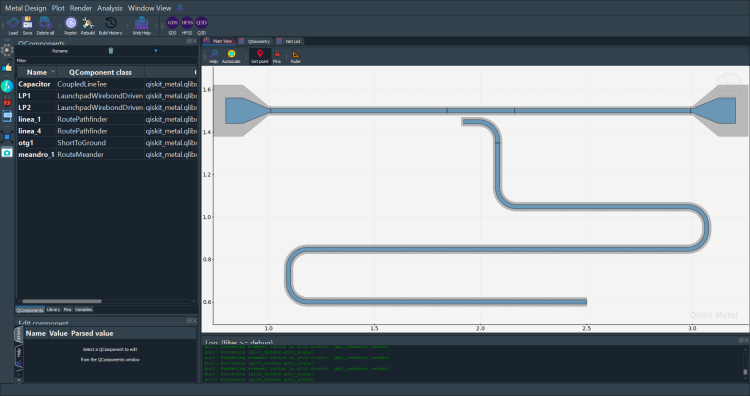

In [30]:
gui.autoscale()
gui.screenshot()

## 4. Librerias Necesarias para la simulacion

### 4.1 Convergencia - Frecuencia

In [22]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_res = EPRanalysis(design, "hfss")

In [23]:
hfss = eig_res.sim.renderer

In [24]:
hfss.start() ## start hfss

INFO 04:33PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:33PM [load_ansys_project]: 	Opened Ansys App
INFO 04:33PM [load_ansys_project]: 	Opened Ansys Desktop v2018.0.0
INFO 04:33PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Quantum Circuits IB/Documents/Ansoft/
	Project:   Project14
INFO 04:33PM [connect_design]: 	Opened active design
	Design:    HFSSDesign1 [Solution type: DrivenModal]
WARNING 04:33PM [connect_setup]: 	No design setup detected.
WARNING 04:33PM [connect_setup]: 	Creating driven modal default setup.
INFO 04:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 04:33PM [connect]: 	Connected to project "Project14" and design "HFSSDesign1" 😀 



True

In [25]:
# clean the design if needed
hfss.clean_active_design()

In [26]:
hfss.activate_ansys_design("Readout", 'eigenmode')  # use new_ansys_design() to force creation of a blank design

04:33PM 28s WARNING [activate_ansys_design]: The design_name=Readout was not in active project.  Designs in active project are: 
['HFSSDesign1'].  A new design will be added to the project.  
INFO 04:33PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
WARNING 04:33PM [connect_setup]: 	No design setup detected.
WARNING 04:33PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [27]:
hfss.render_design([], [])
#hfss.save_screenshot()

In [28]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 10
setup.delta_f=0.01
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

INFO 04:34PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 10
Convergence freq max delta percent diff  = 0.01



In [29]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

04:35PM 27s INFO [get_f_convergence]: Saved convergences to C:\Users\Quantum Circuits IB\Documents\Kelvin\qiskit-metal\script\hfss_eig_f_convergence.csv


### Resonancia

In [30]:
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

In [31]:
design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin LP1_in and LP2_in are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('LP1', 'in', 50),
             ('LP2', 'in', 50)]
box_plus_buffer = True

In [32]:
# we use HFSS as rendere
hfss = em1.renderer
hfss.start()

INFO 04:36PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:36PM [load_ansys_project]: 	Opened Ansys App
INFO 04:36PM [load_ansys_project]: 	Opened Ansys Desktop v2018.0.0
INFO 04:36PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Quantum Circuits IB/Documents/Ansoft/
	Project:   Project14
INFO 04:36PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
INFO 04:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:36PM [connect]: 	Connected to project "Project14" and design "Readout" 😀 



True

In [33]:
# Here we activate the design for a drivenmodal solution
hfss.activate_ansys_design("version_3", 'drivenmodal')
setup_args = Dict(max_delta_s=0.01)
setup_args.name = 'Setup'
hfss.edit_drivenmodal_setup(setup_args)

04:36PM 28s WARNING [activate_ansys_design]: The design_name=version_3 was not in active project.  Designs in active project are: 
['HFSSDesign1', 'Readout'].  A new design will be added to the project.  
INFO 04:36PM [connect_design]: 	Opened active design
	Design:    version_3 [Solution type: DrivenModal]
WARNING 04:36PM [connect_setup]: 	No design setup detected.
WARNING 04:36PM [connect_setup]: 	Creating driven modal default setup.
INFO 04:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
04:36PM 29s WARNING [edit_drivenmodal_setup]: In setup_args, key=max_delta_s, value=0.01 is not in pinfo.setup, the key/value pair from setup_args not added to Setup in Ansys.


In [34]:
# set buffer: espacio alrededor de la geometría que está siendo simulada
hfss.options['x_buffer_width_mm'] = 0.2
hfss.options['y_buffer_width_mm'] = 0.2

In [35]:
# clean the design if needed
hfss.clean_active_design()

In [36]:
# render the design
hfss.render_design(selection=[], 
                   open_pins=open_terminations, 
                   port_list=port_list, 
                   box_plus_buffer = box_plus_buffer)

In [37]:
hfss.modeler.mesh_length(
                'cpw_mesh',
                ['trace_meandro_1'],
                MaxLength='0.010mm')

In [38]:
## usando un step se recomienda que sea 1/10 el ancho de banda.
## para una simulacion, el sweep debe contener a la frecuencia de resonancia
hfss.add_sweep(setup_name="Setup", 
               name="Sweep", 
               start_ghz=5.5,
               stop_ghz=6.5,
               count=100,
               type="Fast")

INFO 04:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


# GDS file

In [31]:
a_gds = design.renderers.gds
### import and place the cell names in the Fake_Junctions
a_gds.options['path_filename'] = 'Fake_Junctions.GDS'

In [32]:
# ### import and place the cell names in the Fake_Junctions
# a_gds.options['path_filename'] = '../Files_mascara/Fake_Junctions.GDS'

In [33]:
## for fillet the short segments, True means no fillet
a_gds.options['short_segments_to_not_fillet'] = 'False'

scale_fillet = 2.0
a_gds.options['check_short_segments_by_scaling_fillet'] = scale_fillet

In [36]:
# Restore a_gds options

a_gds.options.no_cheese['view_in_file']['main']={1: False}
a_gds.options.cheese['view_in_file']['main']={1: False}
a_gds.options['max_points'] = '8191'
a_gds.options['no_cheese']['buffer']='50um'
# We will shift the center of the chip to origin

design.chips.main.size['center_x'] = '2.0mm'
design.chips.main.size['center_y'] = '1.5mm'
design.rebuild()

### For demo, set max_points to 8191 and look at the GDS output.
a_gds.options['max_points'] = '8191'

# We next export it to GDS

design.renderers.gds.export_to_gds("mask/resonator.gds")

1

In [ ]:
#Many ways to view the QGeometry tables.
#If you want to view, uncomment below lines and and run it.

design.qgeometry.tables
# design.qgeometry.tables['path']
# design.qgeometry.tables['poly']